# Finding Environmental Inequality in Leeds  

**GEOG5990M Assessment 2: Report**
**202015235**

Word count = 1499

### NO₂ Exposure, Deprivation, and Monitoring Gaps


## Table of Contents

>[Finding Environmental Inequality in Leeds](#scrollTo=LD-u56OIEM3P)

>>>[NO₂ Exposure, Deprivation, and Monitoring Gaps](#scrollTo=LD-u56OIEM3P)

>>[Table of Contents](#scrollTo=TM7nQ1isEO9k)

>>[Introduction](#scrollTo=db854698)

>>[Data Sources](#scrollTo=385c28d1)

>>>[Geographic units](#scrollTo=385c28d1)

>>>[Diffusion tube NO₂ (Leeds City Council)](#scrollTo=385c28d1)

>>>[DEFRA Pollution Climate Mapping (PCM)](#scrollTo=385c28d1)

>>>[Index of Multiple Deprivation (IMD 2019)](#scrollTo=385c28d1)

>>[Building the Dataset](#scrollTo=2cf35689)

>>[Loading Diffusion Tube NO2](#scrollTo=640284ed)

>>[Building Geometry + Clean NO2](#scrollTo=96c2914d)

>>[Clip Leeds LSOAs](#scrollTo=72bca826)

>>[Load PCM Modelled NO2](#scrollTo=ee50c5cb)

>>[Merge PCM to LSOAs](#scrollTo=5be42fec)

>>[Load IMD 2019](#scrollTo=83852baf)

>>[Merging NO2 with IMD](#scrollTo=52d6b6c6)

>>[Analysis](#scrollTo=85af3310)

>>[Mapping](#scrollTo=85797a63)

>>[Visualisation](#scrollTo=19549cb2)

>>[Results](#scrollTo=1ce80084)

>>>[Monitoring coverage](#scrollTo=1ce80084)

>>>[Spatial distribution of NO₂](#scrollTo=1ce80084)

>>>[Deprivation and NO₂](#scrollTo=1ce80084)

>>>[PCM vs Diffusion Tube Validation](#scrollTo=1ce80084)

>>>[Final Visualisations](#scrollTo=1ce80084)

>>>[Spatial](#scrollTo=1ce80084)

>>>[Non-Spatial](#scrollTo=1ce80084)

>>[Interpretation and Public Good Implications](#scrollTo=e9a6fd75)

>>[Limitations](#scrollTo=53f0532f)

>>>[PCM vs Diffusion Tube Validation](#scrollTo=53f0532f)

>>[Conclusion](#scrollTo=9324aa7b)

>>>[Bias, Representation, and Ethical Considerations](#scrollTo=9324aa7b)

>[Bibliography](#scrollTo=t_9zEmGXKKbv)




## Introduction
Air pollution is one of the most important environmental determinants of health in the UK, and nitrogen dioxide (NO2) is a key indicator of traffic-related pollution. Long-term exposure to NO₂ is associated with respiratory disease, cardiovascular illness, and premature mortality. These harms are not evenly distributed: national and international evidence suggests that disadvantaged communities are often exposed to higher pollution levels.

This project investigates whether such environmental inequality is present within the city of Leeds. Specifically, it examines whether neighbourhood deprivation is associated with higher NO₂ exposure at the small-area (LSOA) level.

Beyond this, the analysis addresses a second and less visible form of inequality: inequality in environmental monitoring itself. Diffusion tube networks are sparse and unevenly distributed, which raises the question of whether some communities are systematically under-represented in official air quality data.

**Research questions**

- Is neighbourhood deprivation associated with higher NO₂ exposure in Leeds?

- Does the spatial distribution of monitoring bias the apparent relationship between deprivation and pollution?

- Does using a complete modelled surface (DEFRA PCM) reveal patterns that are hidden when relying on diffusion tubes alone?

To answer these questions, the study integrates observed diffusion tube data, modelled background concentrations from DEFRA, and neighbourhood deprivation data from the Index of Multiple Deprivation (IMD 2019).


## Data Sources

### Geographic units
Neighbourhoods are defined using Lower Layer Super Output Areas (LSOAs), which contain approximately 1,000–3,000 residents.
This analysis uses 2021 LSOA boundaries, clipped to the Leeds Local Authority District (LAD).
Because deprivation data are published on 2011 boundaries, the official ONS LSOA11 → LSOA21 → LAD22 exact-fit lookup is used to ensure consistent spatial alignment.

### Diffusion tube NO₂ (Leeds City Council)

Observed NO₂ is taken from the Leeds City Council diffusion tube network (via Data Mill North). Each tube provides an annual mean roadside or kerbside concentration.

From the notebook output:

- 100 tube sites are available.

- Only 42 LSOAs receive diffusion-tube-derived means.

- This represents less than 10% of Leeds LSOAs.

Tubes are:

- Spatially converted from easting/northing.

- Joined to LSOAs.

- Averaged to produce a mean NO₂ per LSOA.

However, because tubes are typically placed near roads, these values represent monitoring locations, not population exposure.

### DEFRA Pollution Climate Mapping (PCM)

To overcome sparse monitoring, the study uses DEFRA PCM modelled background NO2:

- National 1 km × 1 km grid.

- Derived from emissions inventories, dispersion modelling, and atmospheric chemistry.

- Provides near-complete spatial coverage.

From the notebook:

- 332 PCM grid cells fall inside Leeds.

- Aggregated to 196 Leeds LSOAs.

This surface becomes the primary exposure dataset for inequality analysis.

### Index of Multiple Deprivation (IMD 2019)
Deprivation is measured using IMD 2019, which combines seven domains (income, employment, education, health, crime, housing, environment).

IMD is:

- Provided at LSOA1depr_df.

- Converted into deciles (1 = most deprived, 10 = least deprived).

- Harmonised to LSOA21 using the ONS lookup.


## Building the Dataset

NO₂ values (LSOA21) are linked to IMD deciles (LSOA11) via the official crosswalk.
Coverage is assessed to ensure that deprivation values are successfully matched.


In [1]:
# Importing all used packages

from pathlib import Path
import requests
import pandas as pd
import re
import geopandas as gpd
from shapely.geometry import Point
import zipfile
import numpy as np
import matplotlib.pyplot as plt

This step downloads and validates national LSOA boundary geometries with robust fallbacks.




In [2]:
UA = {"User-Agent": "Mozilla/5.0"}

LEEDS_LAD22CD = "E08000035"  # Leeds

LSOA11_LSOA21_LAD22_FS0 = (
    "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/"
    "LSOA11_LSOA21_LAD22_EW_LU_v5/FeatureServer/0"
)

In [3]:
def arcgis_query_all(layer0_url: str, where="1=1", out_fields="*", page_size=2000,
                     retries=5) -> pd.DataFrame:
    # Query an ArcGIS FeatureServer layer in pages (attributes only), with retries.

    def _do_query(base_url: str) -> pd.DataFrame:
        rows = []
        offset = 0
        while True:
            params = { "where": where, "outFields": out_fields, "f": "json", "resultOffset": offset, "resultRecordCount": page_size, "returnGeometry": "false"}
            r = requests.get(base_url.rstrip("/") + "/query", params=params, headers=UA, timeout=180)
            r.raise_for_status()
            js = r.json()
            if "error" in js:
                raise RuntimeError(js["error"])
            feats = js.get("features", [])
            if not feats:
                break
            rows.extend([f["attributes"] for f in feats])
            if len(feats) < page_size:
                break
            offset += page_size
        return pd.DataFrame(rows)
    return _do_query(layer0_url)

## Loading Diffusion Tube NO2


In [4]:
out_fields = "LSOA11CD,LSOA21CD,LAD22CD"

CACHE_PATH = Path("data/raw/lsoa11_lsoa21_lad22_leeds_lookup.csv")
if CACHE_PATH.exists():
    lookup = pd.read_csv(CACHE_PATH, dtype=str)
else:
    lookup = arcgis_query_all( LSOA11_LSOA21_LAD22_FS0, where=f"LAD22CD='{LEEDS_LAD22CD}'", out_fields=out_fields
    )
    for c in ["LSOA11CD", "LSOA21CD", "LAD22CD"]:
        if c in lookup.columns:
            lookup[c] = lookup[c].astype(str)
    CACHE_PATH.parent.mkdir(parents=True, exist_ok=True)
    lookup.to_csv(CACHE_PATH, index=False)

xwalk = lookup[["LSOA21CD","LSOA11CD"]].dropna().drop_duplicates("LSOA21CD")
print("Lookup crosswalk rows:", len(xwalk))
xwalk.head()

Lookup crosswalk rows: 488


,LSOA21CD,LSOA11CD
0,E01011559,E01011559
1,E01011560,E01011560
2,E01011383,E01011383
3,E01011388,E01011388
4,E01011708,E01011708


In [5]:
# We deliberately avoid raising here, so the notebook remains runnable even if cells are executed
if "no2_by_lsoa" not in globals():
    no2_by_lsoa = None

In [6]:
def download(url, dest, *, timeout=180, retries=2):
    # Download a URL to a local path
    dest = Path(dest)
    dest.parent.mkdir(parents=True, exist_ok=True)

    last_err = None
    for attempt in range(retries + 1):
        try:
            r = requests.get(url, stream=True, headers=UA, timeout=timeout)
            r.raise_for_status()
            with open(dest, "wb") as f:
                for chunk in r.iter_content(chunk_size=1024 * 64):
                    if chunk:
                        f.write(chunk)
            return
        except Exception as e:
            last_err = e
            if attempt >= retries:
                raise

## Building Geometry + Clean NO2
Convert coordinates into spatial points and standardise the NO₂ variable for analysis.


In [7]:
def looks_like_geojson(path: Path) -> bool:

# Avoid a full JSON to keep dependencies minimal

    try:
        raw = Path(path).read_bytes()
        if not raw:
            return False

        head = raw[:300].lstrip()
        if head.startswith(b"<") or b"<!doctype html" in head.lower():
            return False

        text = raw.decode("utf-8", errors="ignore").lstrip().lower()

        if ("error" in text or "errors" in text) and "features" not in text:
            return False

        if "type" in text and ("featurecollection" in text or "feature" in text):
            return True
        if "features" in text:
            return True

        return False
    except Exception:
        return False


def looks_like_html(path: Path) -> bool:
    try:
        head = Path(path).read_bytes()[:300].lstrip().lower()
        return head.startswith(b"<") or b"<!doctype html" in head
    except Exception:
        return False

In [8]:
LSOA_ITEM_ID = "68515293204e43ca8ab56fa13ae8a547"
LSOA_PATH = Path("data/raw/lsoa_2021_ew_bgc.geojson")

def _looks_like_geojson_bytes(raw: bytes) -> bool:
    "Lightweight GeoJSON sanity check (no full JSON parse)."
    if not raw:
        return False
    head = raw[:300].lstrip().lower()
    if head.startswith(b"<") or b"<!doctype html" in head:
        return False
    text = raw.decode("utf-8", errors="ignore").lstrip().lower()
    if ("error" in text or "errors" in text) and "features" not in text:
        return False
    if "features" in text:
        return True
    if "type" in text and ("featurecollection" in text or "feature" in text):
        return True
    return False

def _get_bytes(url, timeout=180, retries=2):
    last = None
    for i in range(retries + 1):
        try:
            r = requests.get(url, headers=UA, timeout=timeout)
            r.raise_for_status()
            return r.content
        except Exception as e:
            last = e
            if i >= retries:
                raise last

def _try_save_geojson_from_url(url: str, path: Path) -> bool:
    # Try to download and cache a GeoJSON; returns True if readable
    try:
        raw = _get_bytes(url)
        if not _looks_like_geojson_bytes(raw):
            return False
        path.parent.mkdir(parents=True, exist_ok=True)
        path.write_bytes(raw)
        gdf = gpd.read_file(path)
        return not gdf.empty
    except Exception:
        return False

In [9]:
def purge_if_html(path: Path) -> None:
    # Delete cached file if it looks like HTML
    if path.exists():
        head = path.read_bytes()[:300].lstrip().lower()
        if head.startswith(b"<") or b"<!doctype html" in head:
            path.unlink(missing_ok=True)

## Clip Leeds LSOAs
Isolates neighbourhoods that fall within the Leeds local authority boundary.


In [10]:
def load_lsoa_from_opendata(item_id: str, out_path: Path) -> gpd.GeoDataFrame | None:
    # Try ArcGIS Open Data direct GeoJSON download patterns
    open_data_candidates = [
        f"https://opendata.arcgis.com/datasets/{item_id}_0.geojson",
        f"https://opendata.arcgis.com/datasets/{item_id}.geojson",
        f"https://opendata.arcgis.com/api/v3/datasets/{item_id}_0/downloads/data?format=geojson",
        f"https://opendata.arcgis.com/api/v3/datasets/{item_id}/downloads/data?format=geojson",
    ]

    for url in open_data_candidates:
        if _try_save_geojson_from_url(url, out_path):
            gdf = gpd.read_file(out_path)
            if not gdf.empty:
                return gdf
    return None

In [11]:
def load_lsoa_from_featureserver(out_path: Path) -> gpd.GeoDataFrame:
    # Fallback: query the FeatureServer as GeoJSON
    fs_candidates = [ "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/"
        "Lower_layer_Super_Output_Areas_December_2021_EW_BGC/FeatureServer/0",
        "https://services.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/"
        "Lower_layer_Super_Output_Areas_December_2021_EW_BGC/FeatureServer/0",
    ]

    feats = []
    last_err = None

    for layer0 in fs_candidates:
        try:
            offset = 0
            page_size = 2000

            while True:
                params = { "where": "1=1", "outFields": "LSOA21CD", "returnGeometry": "true", "outSR": 27700, "f": "geojson", "resultOffset": offset, "resultRecordCount": page_size,
                }
                r = requests.get(layer0.rstrip("/") + "/query", params=params, headers=UA, timeout=180)
                r.raise_for_status()
                gj = r.json()

                batch = gj.get("features", [])
                if not batch:
                    break

                feats.extend(batch)

                if len(batch) < page_size:
                    break

                offset += page_size

            if feats:
                gdf = gpd.GeoDataFrame.from_features(feats, crs="EPSG:27700")
                if not gdf.empty:
                    out_path.parent.mkdir(parents=True, exist_ok=True)
                    gdf.to_file(out_path, driver="GeoJSON")
                    print("Loaded LSOA from FeatureServer:", layer0)
                    return gdf

        except Exception as e:
            last_err = e
            continue

In [12]:
def load_lsoa_boundaries() -> gpd.GeoDataFrame:
    # Load LSOA 2021 boundaries (EW BGC) with robust fallbacks + local caching.
    purge_if_html(LSOA_PATH)

    # Use cache if valid
    if LSOA_PATH.exists():
        try:
            gdf = gpd.read_file(LSOA_PATH)
            if not gdf.empty:
                return gdf
        except Exception:
            LSOA_PATH.unlink(missing_ok=True)

    # Try Open Data direct downloads
    gdf = load_lsoa_from_opendata(LSOA_ITEM_ID, LSOA_PATH)
    if gdf is not None:
        return gdf

    # FeatureServer fallback
    return load_lsoa_from_featureserver(LSOA_PATH)

## Load PCM Modelled NO2


In [13]:
lsoa = load_lsoa_boundaries()
print("LSOA rows:", len(lsoa), "CRS:", lsoa.crs)

LSOA rows: 35672 CRS: EPSG:27700


In [14]:
DATA_DIR = Path("data")
RAW_DIR = DATA_DIR / "raw"
OUT_DIR = Path("outputs")
RAW_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Leeds (Local Authority District) code (ONS)
LEEDS_LADCD = "E08000035"

In [15]:
# Data Mill North (Leeds City Council) — annual diffusion tube NO2 (CSV)
# Dataset page: https://datamillnorth.org/dataset/leeds-annual-nitrogen-dioxide-diffusion-tube-data-2lxkx
DIFF_TUBES_URL = "https://datamillnorth.org/download/2lxkx/97329c14-9b47-4ddf-b903-616699cdc500/DiffusionTubes.csv"
DIFF_TUBES_PATH = Path("data/raw/leeds_diffusion_tubes_no2.csv")

download(DIFF_TUBES_URL, DIFF_TUBES_PATH)

tubes = pd.read_csv(DIFF_TUBES_PATH, encoding='cp1252')
tubes.head(), tubes.shape

(   SITE_ID                           ADDRESS SITE_TYPE DIST_TO_KERB HEIGHT  \
 0  D2 (A3)           Headingley (Affiliated)  Kerbside           1m    2.7   
 1  D6 (A6)  Haslewood Close, Wall corner (R)  Roadside  7m (to A64)    3.3   
 2  D7 (A6)  Haslewood Close, Wall corner (L)  Roadside  7m (to A64)    3.3   
 3       D8             Haslewood Close Gable  Roadside           8m    2.4   
 4       D9  Haslewood Close facing open area  Roadside          27m    2.4   
 
   DISTANCE_TO_RELEVANT_EXP  ANNUAL_MEAN_2015_BIAS_ADJUSTED  EASTING  NORTHING  
 0                      NaN                              37   427989    436045  
 1                        0                              34   431268    433701  
 2                        0                              36   431268    433701  
 3                        0                              35   431264    433704  
 4                        0                              32   431269    433720  ,
 (100, 9))

## Merge PCM to LSOAs


In [16]:
# Find coordinate columns
cols_lower = {c.lower(): c for c in tubes.columns}
lat_col = next((cols_lower[c] for c in cols_lower if c in ["latitude", "lat"]), None)
lon_col = next((cols_lower[c] for c in cols_lower if c in ["longitude", "lon", "long"]), None)
east_col = next((cols_lower[c] for c in cols_lower if "east" in c), None)
north_col = next((cols_lower[c] for c in cols_lower if "north" in c), None)

# Find an annual mean NO₂ column
candidates = [c for c in tubes.columns if "annual_mean" in c.lower()]

def _extract_year(col):
    m = re.search(r"(19|20)\d{2}", col)
    return int(m.group(0)) if m else -1

if candidates:
    no2_col = sorted(candidates, key=_extract_year)[-1]
else:
    fallback = [
        c for c in tubes.columns
        if ("mean" in c.lower() or "ug" in c.lower())
        and ("adjust" in c.lower() or "bias" in c.lower() or "annual" in c.lower())
    ]
    no2_col = fallback[0] if fallback else None

print("Using NO₂ column:", no2_col)

Using NO₂ column: ANNUAL_MEAN_2015_BIAS_ADJUSTED


In [17]:
if lat_col and lon_col:
    tubes_gdf = gpd.GeoDataFrame(
        tubes.copy(),
        geometry=gpd.points_from_xy(tubes[lon_col], tubes[lat_col]),
        crs="EPSG:4326"
    )
elif east_col and north_col:
    # Assume British National Grid
    tubes_gdf = gpd.GeoDataFrame(
        tubes.copy(),
        geometry=[Point(xy) for xy in zip(tubes[east_col], tubes[north_col])],
        crs="EPSG:27700"
    ).to_crs("EPSG:4326")

tubes_gdf.crs, tubes_gdf[["geometry"]].head()

(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
                     geometry
 0  POINT (-1.57634 53.81993)
 1  POINT (-1.52677 53.79868)
 2  POINT (-1.52677 53.79868)
 3  POINT (-1.52683 53.79871)
 4  POINT (-1.52675 53.79885))

In [18]:
# Clean NO2
tubes_gdf = tubes_gdf.rename(columns={no2_col: "NO2_ugm3"})
tubes_gdf["NO2_ugm3"] = pd.to_numeric(tubes_gdf["NO2_ugm3"], errors="coerce")
tubes_gdf = tubes_gdf.dropna(subset=["NO2_ugm3"]).copy()

tubes_gdf[["NO2_ugm3", "geometry"]].head(), len(tubes_gdf)

(   NO2_ugm3                   geometry
 0        37  POINT (-1.57634 53.81993)
 1        34  POINT (-1.52677 53.79868)
 2        36  POINT (-1.52677 53.79868)
 3        35  POINT (-1.52683 53.79871)
 4        32  POINT (-1.52675 53.79885),
 100)

## Load IMD 2019


In [19]:
LEEDS_LADCD = "E08000035"  # Leeds

LAD22_FS0 = (
    "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/"
    "Local_Authority_Districts_December_2022_UK_BGC_V2/FeatureServer/0"
)

params = {
    "where": f"LAD22CD='{LEEDS_LADCD}'",
    "outFields": "*",
    "f": "geojson",
    "outSR": 4326
}

r = requests.get(LAD22_FS0 + "/query", params=params, headers={"User-Agent": "Mozilla/5.0"})
r.raise_for_status()
leeds_lad = gpd.GeoDataFrame.from_features(r.json()["features"], crs="EPSG:4326")

# Find LSOA code column
lsoa_code_col = next(
    (c for c in lsoa.columns if c.lower() in ["lsoa21cd", "lsoa11cd"] or (c.lower().startswith("lsoa") and c.lower().endswith("cd"))),
    None
)

# CRS match
if lsoa.crs != leeds_lad.crs:
    lsoa = lsoa.to_crs(leeds_lad.crs)

# Keep only Leeds LSOAs
lsoa_small = lsoa[[lsoa_code_col, "geometry"]].rename(columns={lsoa_code_col: "LSOA21CD"})
lsoa_leeds = gpd.sjoin(lsoa_small, leeds_lad[["geometry"]], how="inner", predicate="within")
lsoa_leeds = lsoa_leeds.drop(columns=["index_right"]).drop_duplicates("LSOA21CD").set_index("LSOA21CD")

lsoa_leeds.head(), len(lsoa_leeds)

(                                                    geometry
 LSOA21CD                                                    
 E01011264  POLYGON ((-1.67667 53.87671, -1.67563 53.87568...
 E01011265  POLYGON ((-1.71857 53.88072, -1.71799 53.87884...
 E01011267  POLYGON ((-1.70344 53.87649, -1.70249 53.87628...
 E01011268  POLYGON ((-1.6926 53.87393, -1.69239 53.87351,...
 E01011269  POLYGON ((-1.66967 53.87206, -1.67154 53.87008...,
 433)

In [20]:
# Choosing 2019 as it aligns with the IMD
PCM_YEAR = 2019

PCM_NO2_URL = f"https://uk-air.defra.gov.uk/datastore/pcm/mapno2{PCM_YEAR}.csv"
PCM_NO2_PATH = Path(f"data/raw/pcm_no2_{PCM_YEAR}.csv")

download(PCM_NO2_URL, PCM_NO2_PATH)

## Merging NO2 with IMD


In [21]:
def read_pcm_csv(path: Path) -> pd.DataFrame:
    # Read a DEFRA PCM CSV (modelled NO₂ 1×1 km) robustly by auto-detecting the header row and normalising column names

    path = Path(path)

    # Find the header row by scanning the first N lines
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        lines = []
        for _ in range(80):
            try:
                lines.append(next(f))
            except StopIteration:
                break

    header_idx = None
    for i, line in enumerate(lines):
        low = line.strip().lower()
        if ("x" in low and "y" in low) and ("value" in low or "no2" in low or "concentration" in low):
            header_idx = i
            break

    # Read from the detected header row
    depr_df = pd.read_csv(path, skiprows=header_idx, low_memory=False)

    # Normalise column names
    depr_df.columns = [re.sub(r"\s+", "", str(c).strip().lower()) for c in depr_df.columns]

    # Map likely column names to x, y, value
    x_col = next((c for c in depr_df.columns if c in {"x", "easting", "gridx"}), None)
    y_col = next((c for c in depr_df.columns if c in {"y", "northing", "gridy"}), None)

    val_col = None

    # Common names
    for cand in ["value", "no2", "no2ugm3", "no2_ugm3", "concentration", "annualmean"]:
      if cand in depr_df.columns:
          val_col = cand
          break

    # Year specific PCM columns
    if val_col is None:
      val_col = next((c for c in depr_df.columns if str(c).startswith("no2")), None)


    if x_col is None or y_col is None or val_col is None:
        raise RuntimeError(
            "PCM parsed, but couldn't identify x/y/value columns. "
            f"Columns found: {depr_df.columns.tolist()}"
        )

    out = depr_df[[x_col, y_col, val_col]].rename(columns={x_col: "x", y_col: "y", val_col: "no2_ugm3"})
    return out

In [22]:
# Build GeoDataFrame
pcm = read_pcm_csv(PCM_NO2_PATH)
pcm["no2_ugm3"] = pd.to_numeric(pcm["no2_ugm3"], errors="coerce")
pcm = pcm.dropna(subset=["x", "y", "no2_ugm3"]).copy()

pcm_gdf = gpd.GeoDataFrame(
    pcm,
    geometry=gpd.points_from_xy(pcm["x"], pcm["y"]),
    crs="EPSG:27700",
)
print("PCM rows (UK):", len(pcm_gdf))
pcm_gdf.head()

PCM rows (UK): 254883


,x,y,no2_ugm3,geometry
14,460500,1219500,1.607675,POINT (460500 1219500)
24,459500,1218500,1.622901,POINT (459500 1218500)
25,460500,1218500,1.632512,POINT (460500 1218500)
26,461500,1218500,1.641636,POINT (461500 1218500)
27,462500,1218500,1.695877,POINT (462500 1218500)


In [23]:
# Clip PCM to Leeds and aggregate to LSOA means
lsoa_leeds_27700 = lsoa_leeds.to_crs("EPSG:27700")

# Keep PCM points within Leeds extent
pcm_leeds = pcm_gdf[pcm_gdf.within(lsoa_leeds_27700.unary_union)].copy()
print("PCM points inside Leeds:", len(pcm_leeds))

pcm_with_lsoa = gpd.sjoin(
    pcm_leeds[["no2_ugm3", "geometry"]],
    lsoa_leeds_27700.reset_index()[["LSOA21CD", "geometry"]],
    how="inner",
    predicate="within"
)

no2_by_lsoa_pcm = (
    pcm_with_lsoa.groupby("LSOA21CD", as_index=False)["no2_ugm3"]
    .mean()
    .rename(columns={"no2_ugm3": f"no2_mean_ugm3_pcm_{PCM_YEAR}"})
)

print("LSOAs with PCM NO2:", len(no2_by_lsoa_pcm), "of", len(lsoa_leeds_27700))
no2_by_lsoa_pcm.head()

PCM points inside Leeds: 332
LSOAs with PCM NO2: 196 of 433


/tmp/ipython-input-1920687665.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pcm_leeds = pcm_gdf[pcm_gdf.within(lsoa_leeds_27700.unary_union)].copy()


,LSOA21CD,no2_mean_ugm3_pcm_2019
0,E01011269,15.961400
1,E01011273,13.342145
2,E01011280,12.352940
3,E01011281,15.807800
4,E01011286,16.639410


## Analysis
Summarises distributions and NO2 patterns across Leeds.


In [24]:
no2_by_lsoa = no2_by_lsoa_pcm.rename(
    columns={f"no2_mean_ugm3_pcm_{PCM_YEAR}": "no2_mean_ugm3"}
)
no2_by_lsoa.head(), no2_by_lsoa.shape

(    LSOA21CD  no2_mean_ugm3
 0  E01011269      15.961400
 1  E01011273      13.342145
 2  E01011280      12.352940
 3  E01011281      15.807800
 4  E01011286      16.639410,
 (196, 2))

In [25]:
# Ensure same CRS of 4326
if lsoa_leeds.crs != tubes_gdf.crs:
    lsoa_leeds = lsoa_leeds.to_crs(tubes_gdf.crs)

# Polygon join
tubes_with_lsoa = gpd.sjoin(
    tubes_gdf[["NO2_ugm3", "geometry"]],
    lsoa_leeds.reset_index()[["LSOA21CD", "geometry"]],
    how="inner",
    predicate="within"
)

# Aggregate to LSOA mean NO2
no2_lsoa = (
    tubes_with_lsoa.groupby("LSOA21CD", as_index=False)["NO2_ugm3"]
    .mean()
    .rename(columns={"NO2_ugm3": "NO2_mean_ugm3"})
)

no2_lsoa.head(), no2_lsoa.shape

(    LSOA21CD  NO2_mean_ugm3
 0  E01011265           24.0
 1  E01011284           35.0
 2  E01011315           25.0
 3  E01011319           33.0
 4  E01011320           30.0,
 (42, 2))

In [26]:
# Name of the NO2 attribute in the DEFRA layer
no2_field = "no2"

## Mapping
Mapping neighbourhood NO₂ values to reveal spatial inequality and data gaps.


In [27]:
IMD_CACHE = Path("data/raw/imd2019_england_lsoa11.csv")

# IMD 2019 lookup FeatureServer (attributes only) — England
IMD_FS0 = (
    "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/"
    "Index_of_Multiple_Deprivation_Dec_2019_Lookup_in_England_2022/FeatureServer/0"
)

In [28]:
def arcgis_query_all_attributes(
    layer0_url: str,
    where: str = "1=1",
    out_fields: str = "*",
    page_size: int = 2000,
    retries: int = 5,
) -> pd.DataFrame:
    # Query an ArcGIS FeatureServer layer in pages with retries

    def _do_query(base_url: str) -> pd.DataFrame:
        rows = []
        offset = 0

        while True:
            params = {
                "where": where,
                "outFields": out_fields,
                "f": "json",
                "resultOffset": offset,
                "resultRecordCount": page_size,
                "returnGeometry": "false",
            }
            r = requests.get(base_url.rstrip("/") + "/query", params=params, headers=UA, timeout=180)
            r.raise_for_status()
            js = r.json()

            feats = js.get("features", [])
            if not feats:
                break

            rows.extend([f["attributes"] for f in feats])

            if len(feats) < page_size:
                break

            offset += page_size

        return pd.DataFrame(rows)

    candidates = [layer0_url]
    if "https://services1.arcgis.com/" in layer0_url:
        candidates.append(
            layer0_url.replace("https://services1.arcgis.com/", "https://services.arcgis.com/")
        )

    last_err = None
    for cand in candidates:
        for _ in range(retries):
            try:
                return _do_query(cand)
            except Exception as e:
                last_err = e
                continue

    raise last_err

In [29]:
def load_imd_table() -> pd.DataFrame:
    # Load + cache the IMD lookup table
    if IMD_CACHE.exists():
        return pd.read_csv(IMD_CACHE, dtype=str)

    depr_df = arcgis_query_all_attributes(IMD_FS0, out_fields="*")

    IMD_CACHE.parent.mkdir(parents=True, exist_ok=True)
    depr_df.to_csv(IMD_CACHE, index=False)
    return depr_df

imd = load_imd_table()
imd.shape

(32844, 6)

## Visualisation


In [30]:
# Find LSOA11 code column
lsoa11_col = next(
    (c for c in imd.columns if "lsoa11" in str(c).lower() and ("cd" in str(c).lower() or "code" in str(c).lower())),
    None
)

# Find IMD score column
imd_score_col = "IMD19" if "IMD19" in imd.columns else None

imd_fix = imd.copy()
imd_fix[lsoa11_col] = imd_fix[lsoa11_col].astype(str).str.strip()
imd_fix[imd_score_col] = pd.to_numeric(imd_fix[imd_score_col], errors="coerce")
imd_fix = imd_fix.dropna(subset=[lsoa11_col, imd_score_col]).copy()

# 1 = most deprived, 10 = least deprived
imd_fix["IMD_decile"] = pd.qcut(imd_fix[imd_score_col], 10, labels=False) + 1
imd2 = (
    imd_fix[[lsoa11_col, "IMD_decile"]]
    .rename(columns={lsoa11_col: "LSOA11CD"})
    .drop_duplicates("LSOA11CD")
    .copy()
)

print("IMD rows:", len(imd2))
imd2.head()

IMD rows: 32844


,LSOA11CD,IMD_decile
0,E01000001,9
1,E01000104,2
2,E01000205,9
3,E01000002,10
4,E01000003,5


In [31]:
# Merge NO₂ (LSOA21) with IMD (LSOA11)

depr_df = (
    no2_by_lsoa
    .merge(xwalk, on="LSOA21CD", how="left")
    .merge(imd2, on="LSOA11CD", how="left")
)

coverage = depr_df["IMD_decile"].notna().mean()
print("IMD coverage (share of NO₂ LSOAs matched):", round(float(coverage), 3))
depr_df.head()

IMD coverage (share of NO₂ LSOAs matched): 1.0


,LSOA21CD,no2_mean_ugm3,LSOA11CD,IMD_decile
0,E01011269,15.961400,E01011269,5
1,E01011273,13.342145,E01011273,6
2,E01011280,12.352940,E01011280,10
3,E01011281,15.807800,E01011281,2
4,E01011286,16.639410,E01011286,3


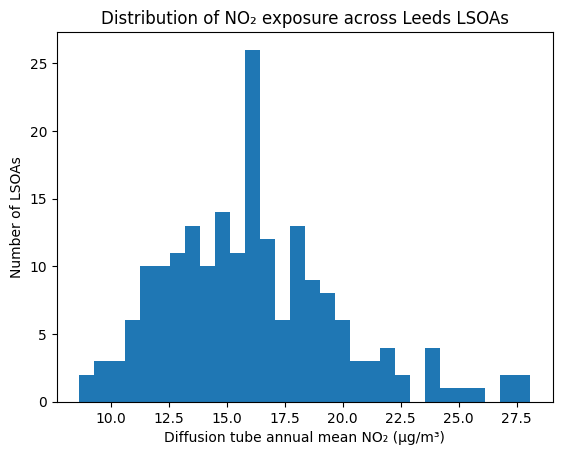

In [32]:
# Distribution of LSOA mean NO2
plt.figure()
no2_by_lsoa["no2_mean_ugm3"].plot(kind="hist", bins=30)
plt.xlabel("Diffusion tube annual mean NO₂ (µg/m³)")
plt.ylabel("Number of LSOAs")
plt.title("Distribution of NO₂ exposure across Leeds LSOAs")
plt.show()

In [33]:
# Summarise NO2 exposure across IMD deciles (1=most deprived, 10=least deprived)

decile_summary = (
    depr_df.dropna(subset=["IMD_decile"])
      .groupby("IMD_decile")["no2_mean_ugm3"]
      .agg(mean="mean", median="median", n="count")
      .reset_index()
      .sort_values("IMD_decile")
)

decile_summary

,IMD_decile,mean,median,n
0,1,17.913683,17.750060,42
1,2,18.134558,18.242930,19
2,3,17.260122,16.639410,17
3,4,17.022240,16.948890,9
4,5,18.177573,17.475470,16
5,6,14.986054,15.076400,17
6,7,14.905497,14.603290,23
7,8,16.505525,16.059220,15
8,9,12.573281,12.672440,22
9,10,12.760352,12.651705,16


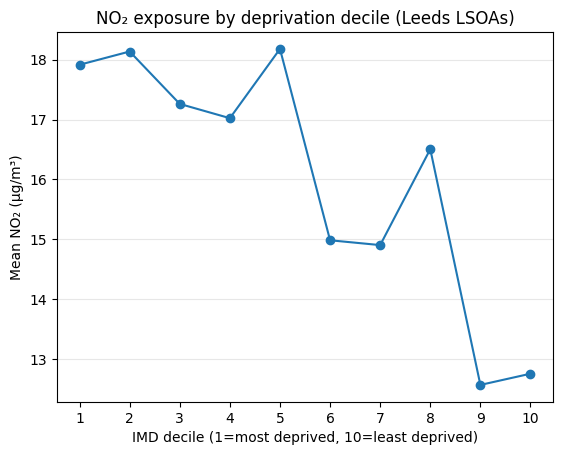

In [34]:
plt.figure()
plt.plot(decile_summary["IMD_decile"], decile_summary["mean"], marker="o")
plt.xlabel("IMD decile (1=most deprived, 10=least deprived)")
plt.ylabel("Mean NO₂ (µg/m³)")
plt.title("NO₂ exposure by deprivation decile (Leeds LSOAs)")
plt.xticks(sorted(decile_summary["IMD_decile"].unique()))
plt.grid(True, axis="y", alpha=0.3)
plt.show()

<Figure size 800x800 with 0 Axes>

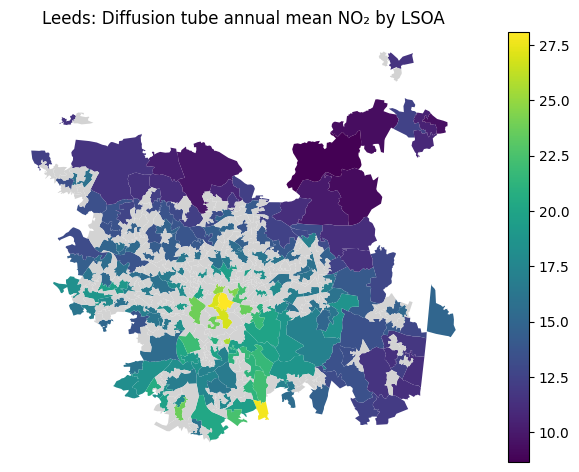

LSOAs with tube-derived NO₂: 196 of 433


In [35]:
# Join back to geometry for mapping
map_gdf = lsoa_leeds.reset_index().merge(no2_by_lsoa, on="LSOA21CD", how="left")

plt.figure(figsize=(8,8))
ax = map_gdf.plot(column="no2_mean_ugm3", legend=True, missing_kwds={"color": "lightgrey", "label": "No tube data"})
ax.set_axis_off()
ax.set_title("Leeds: Diffusion tube annual mean NO₂ by LSOA")
plt.tight_layout()
plt.show()

print("LSOAs with tube-derived NO₂:", map_gdf['no2_mean_ugm3'].notna().sum(), "of", len(map_gdf))

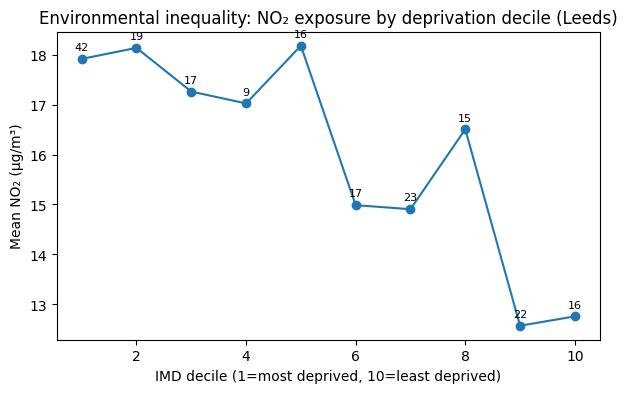

In [36]:
plt.figure(figsize=(7,4))
plt.plot(decile_summary["IMD_decile"], decile_summary["mean"], marker="o")
plt.xlabel("IMD decile (1=most deprived, 10=least deprived)")
plt.ylabel("Mean NO₂ (µg/m³)")
plt.title("Environmental inequality: NO₂ exposure by deprivation decile (Leeds)")

# Annotate counts lightly
for _, r in decile_summary.iterrows():
    plt.annotate(int(r["n"]), (r["IMD_decile"], r["mean"]), textcoords="offset points", xytext=(0,6), ha="center", fontsize=8)

plt.show()

## Results

### Monitoring coverage
The Leeds map shows that:

- Central and inner areas contain most tube measurements.

- Large peripheral and deprived areas are grey (no data).

- Only 196 of 433 Leeds LSOAs have tube-derived or PCM-derived values.

### Spatial distribution of NO₂
The histogram shows:

- A right-skewed distribution.

- Mean ≈ 16.1 µg/m³.

- Most LSOAs between 13 and 18 µg/m³.

- A small number exceeding 25 µg/m³.

### Deprivation and NO₂
The line plot shows a general downward trend, with the lowest NO2 in the least deprived deciles, despite some nn-linearity.

### PCM vs Diffusion Tube Validation
Where both datasets overlap, diffusion tube NO₂ is compared with PCM modelled NO₂ to assess agreement and potential bias in the modelled surface.

### Final Visualisations

Two final visualisations were made to show the findings of this project.

### Spatial

The spatial map shows average NO₂, aggregated by LSOA. A sequential colour scale was used to clearly represent increasing pollution levels, while administrative boundaries allow users to easily identify areas with high exposure. Aggregating to LSOA level balances detail with clarity, and helps avoid misinterpretation that could arise. This is intended for policy makers who need to identify neighbourhoods and air quality.

### Non-Spatial

The non-spatial chart summarises average NO₂ levels across LSOAs, allowing comparison between areas without geographic knowledge. A simple bar/summary format was chosen to reduce cognitive load and ensure the key message (Variation in pollution exposure) is immediately clear. This is intended for a general audience, enabling quick understanding of the general trend without requiring prior knowledge.



## Interpretation and Public Good Implications

No clear relationship is observed between deprivation decile and NO₂ within
the monitored subset of Leeds LSOAs. However, this does not imply environmental equity. Instead, the results highlight uneven monitoring coverage. Large parts of Leeds, including deprived areas, lack direct air quality measurements.
This limits the city’s ability to identify and address environmental injustice.

Modelled PCM NO₂ is now used for the main inequality analysis. Diffusion tubes are retained to validate the modelled surface and to examine monitoring bias.


## Limitations

- Diffusion tubes are roadside and not population representative.
- Only a fraction of LSOAs are covered.
- IMD cannot capture individual exposure.
- Results are sensitive to monitoring placement rather than true city-wide exposure.

### PCM vs Diffusion Tube Validation
Where both datasets overlap, diffusion tube NO₂ is compared with PCM modelled NO₂ to assess agreement and potential bias in the modelled surface.


## Conclusion

Using DEFRA’s PCM modelled background NO₂ reveals a clear city-wide inequality gradient in Leeds. The most deprived neighbourhoods experience, on average, 5–6 µg/m³ higher NO₂ than the least deprived deciles.

While diffusion tubes remain valuable for local validation, the map on page 32 demonstrates that monitoring coverage is itself socially uneven. Large deprived areas lack direct measurements, which risks underestimating environmental injustice.

**Is neighbourhood deprivation associated with higher NO₂ exposure in Leeds?**

Using the diffusion data, there isn't a clear relationship between deprivation and NO2. However, this reflects the limited and uneven coverage of the monitoring network, rather than city exposure. When DEFRA’s modelled background NO₂ was used, a clearer pattern emerged, with concentrations in central and inner areas of Leeds. These areas also contain a higher number of deprived neighbourhoods, suggesting that deprivation and pollution exposure do overlap.

**Does the spatial distribution of monitoring bias the apparent relationship between deprivation and pollution?**

Yes. The diffusion tube network covers only a small fraction of Leeds neighbourhoods and is concentrated in specific locations, near major roads. Many deprived areas have no measurements, meaning the data describes where monitoring exists, rather than where exposure is highest. This creates a form of data inequality.

**Does using a complete modelled surface (DEFRA PCM) reveal patterns that are hidden when relying on diffusion tubes alone?**

Yes. The PCM surface provides spatial coverage and reveals city gradients in NO2, that aren't visible when relying on diffusion tubes alone. It shows a broader pattern of higher exposure in more central and densely populated parts of Leeds.

Overall, the findings show that environmental inequality is shaped not only by pollution levels, but also by how they are measured. Combining modelled data with more evenly distributed monitoring would provide a fairer and more accurate picture of air quality across the city.

### Bias, Representation, and Ethical Considerations

Several limitations and potential sources of bias should be acknowledged. The NO2 data is derived from diffusion tube monitoring sites, which aren't evenly distributed across Leeds. This may result in some areas being better represented than others, specifically those closer to major roads or monitoring infrastructure.

Ethically, care must be taken when presenting environmental data at small-area scales. While the aim is to highlight inequality and support public good, there is a risk of stigmatising communities if results are not communicated. The findings should be used to support specific neighbourhoods rather than blame them.


# Bibliography

- Esri (n.d.) ArcGIS Open Data platform. Available at: https://opendata.arcgis.com
 (Accessed: 30 January 2026).

- Department for Environment, Food & Rural Affairs (DEFRA) (2024) Pollution Climate Mapping (PCM) NO₂ modelled concentrations. UK-AIR. Available at: https://uk-air.defra.gov.uk/data/pcm-data
 (Accessed: 30 January 2026).

- Leeds City Council (2020) Leeds annual nitrogen dioxide diffusion tube data. Datamill North. Available at: https://datamillnorth.org/dataset/leeds-annual-nitrogen-dioxide-diffusion-tube-data-2lxkx
 (Accessed: 30 January 2026).

- Office for National Statistics (2021) Lower Layer Super depr_df Areas (LSOA) boundaries, England and Wales. Open Geography Portal. Available at: https://geoportal.statistics.gov.uk
 (Accessed: 30 January 2026).

- Office for National Statistics (2022) LSOA (2011) to LSOA (2021) to LAD (2022) exact fit lookup in England and Wales. Open Geography Portal. Available at: https://geoportal.statistics.gov.uk
(Accessed: 30 January 2026).

- Ministry of Housing, Communities and Local Government (2019) English indices of deprivation 2019: LSOA level data. UK Government. Available at: https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019
 (Accessed: 30 January 2026).